
## Implementación y resolución como problema cuádratico de la formulación dual SVM con holgura y kernel.
**Integrantes**
> Mario Mallea, Maximiliano Ramírez y Hugo Rocha.

**Descripción**
> En este cuaderno resolveremos el problema de clasificación via solver cvxopt el problema dual tipo SVM.

**Herramientas**
> Python version 3.7.9; version 1.2.5 de cvxopt 



In [54]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)


Python version
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


version 1.2.5 de cvxopt

In [55]:
pip install cvxopt

Note: you may need to restart the kernel to use updated packages.


Cargamos las librerias a utilizar:

In [56]:
import numpy as np
import random
import pandas as pd
from cvxopt import matrix, solvers
from sklearn.datasets import load_breast_cancer
from datetime import datetime
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt


Cargamos los datos del cancer mamario

In [57]:
dataframe = load_breast_cancer()
df = pd.DataFrame(np.c_[dataframe['data'], dataframe['target']],
                  columns= np.append(dataframe['feature_names'], ['target']))

data = df.values
ix = [i for i in range(data.shape[1]) if i != df.shape[1]-1]
X, y = data[:, ix], data[:, df.shape[1]-1]




for i in range(y.shape[0]): ## transformamos las etiquetas a clasificar 
    if y[i]==0: 
        y[i]=-1 #benigno es -1, maligo se queda con 1
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Definimos diferentes kernels

In [58]:
def poly_kernel(x, z, degree, intercept):
        return np.power(np.matmul(x, z.T) + intercept, degree)

def gaussian_kernel(x, z):
    sigma = 1/((len(df.columns)-1)*X.var()) # por defecto en sktlearn
    return np.exp(-np.sum((x-z)**2)/(2*sigma**2))

def linear_kernel(x, z):
    return np.matmul(x, z.T)

Establecemos el problema como uno progrmación cuadrática y resolvemos con solver obteniendo los multiplicadores de Lagrange:

In [59]:
import numpy as np
import cvxopt
def fit(X, y, kernel, C):
    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = kernel(X[i], X[j])
            
    P = cvxopt.matrix(np.outer(y,y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1,n_samples))
    b = cvxopt.matrix(0.0)
    if C is None:      # hard-margin SVM
       G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
       h = cvxopt.matrix(np.zeros(n_samples))
    else:              # soft-margin SVM
       G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
       h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    # Resuelve problema cuadrático QP
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    print(solution)
    # multiplicadores
    a = np.ravel(solution['x'])
    # vectores de soporte con multiplicadores de lagrange no nulos
    
    return a
    

Establecemos un criterio de convergencia y predecimos

# Caso Kernel Lineal y reguralización =100

In [60]:
a= fit(X_train, y_train, linear_kernel, 100)
ind = (a > 1e-4).flatten()
sv = X_train[ind]
sv_y = y_train[ind]
alphas = a[ind]



     pcost       dcost       gap    pres   dres
 0:  5.0903e+03 -2.1362e+06  5e+06  6e-01  8e-07
 1:  9.9345e+03 -8.1552e+05  1e+06  2e-01  4e-07
 2:  8.7265e+03 -4.3656e+05  7e+05  7e-02  3e-07
 3:  4.6473e+03 -1.6971e+05  2e+05  2e-02  2e-07
 4:  2.1750e+03 -6.9113e+04  9e+04  5e-03  1e-07
 5: -3.4831e+01 -1.9138e+04  2e+04  7e-04  1e-07
 6: -8.9233e+02 -6.8594e+03  6e+03  1e-04  1e-07
 7: -1.2031e+03 -4.8062e+03  4e+03  4e-05  2e-07
 8: -1.3424e+03 -4.7165e+03  3e+03  4e-05  2e-07
 9: -1.3986e+03 -4.1099e+03  3e+03  1e-05  2e-07
10: -1.6384e+03 -3.2267e+03  2e+03  6e-06  2e-07
11: -1.6918e+03 -2.7392e+03  1e+03  2e-06  2e-07
12: -1.8038e+03 -2.5178e+03  7e+02  8e-07  2e-07
13: -1.9033e+03 -2.1932e+03  3e+02  2e-13  2e-07
14: -1.9623e+03 -2.0995e+03  1e+02  3e-14  2e-07
15: -2.0125e+03 -2.0181e+03  6e+00  3e-14  3e-07
16: -2.0146e+03 -2.0147e+03  1e-01  5e-13  3e-07
17: -2.0146e+03 -2.0146e+03  1e-03  1e-14  3e-07
18: -2.0146e+03 -2.0146e+03  1e-05  3e-13  2e-07
19: -2.0146e+03 -2.01

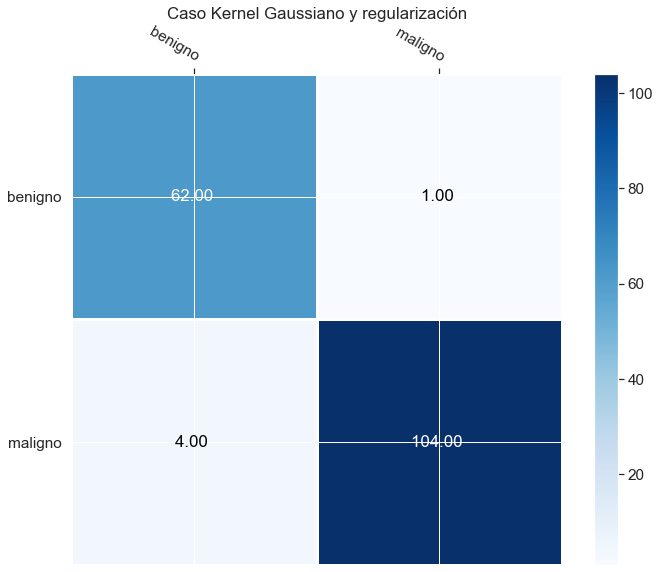

In [61]:
b = sv_y - np.sum(linear_kernel(sv, sv) * alphas * sv_y, axis=0)
b = np.sum(b) / b.size

predictions=[]
for i in range(X_test.shape[0]):
    prod=np.sum(linear_kernel(sv, X_test[i,:]).T * alphas * sv_y, axis=0) + b
    predictions.append(np.sign(prod))
    
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, range(2), range(2))
df_cm.columns=['benigno','maligno']
from mpl_heatmap import heatmap, annotate_heatmap #Reciclo un mapa de calor ocupado por usted en una de sus clases 
fig, ax = plt.subplots(figsize=(10, 8))
im, cbar = heatmap(
    df_cm, # valores
    df_cm.columns, # filas
    df_cm.columns, # columnas
    ax=ax, # ventana
    cmap=plt.cm.Blues,  # gama de colores
    #cbarlabel="indice" # nombre barra de colores
)
texts = annotate_heatmap(im, valfmt="{x:.2f} ")
fig.tight_layout()
plt.title('Caso Kernel Lineal y regularización')
plt.show()

# Caso Kernel Gaussiano y regularización =100

     pcost       dcost       gap    pres   dres
 0:  1.9876e+05 -5.0319e+05  7e+05  1e-12  2e-14
 1:  3.8519e+04 -5.2991e+04  9e+04  4e-12  8e-15
 2:  4.8933e+03 -8.3004e+03  1e+04  3e-12  4e-15
 3:  3.5535e+02 -1.4629e+03  2e+03  7e-13  8e-16
 4: -1.5384e+02 -3.8630e+02  2e+02  3e-13  1e-16
 5: -1.8615e+02 -2.0194e+02  2e+01  3e-13  9e-17
 6: -1.8644e+02 -1.8662e+02  2e-01  3e-14  6e-17
 7: -1.8644e+02 -1.8644e+02  2e-03  1e-13  7e-17
 8: -1.8644e+02 -1.8644e+02  2e-05  1e-13  4e-17
Optimal solution found.
{'x': <398x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <796x1 matrix, tc='d'>, 'z': <796x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.8238246478074516e-05, 'relative gap': 9.7825154285244e-08, 'primal objective': -186.43718592964777, 'dual objective': -186.4372041678942, 'primal infeasibility': 1.1612932837579137e-13, 'dual infeasibility': 4.4488932650596466e-17, 'primal slack': 0.7487437540661077, 'dual slack': 1.438055707635192e-11, 'iterations': 8}


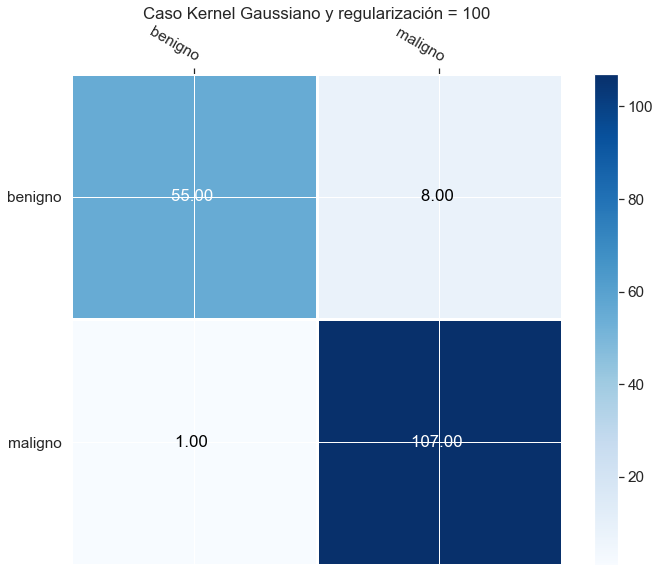

In [62]:
a= fit(X_train, y_train, gaussian_kernel, 100)
ind = (a > 1e-4).flatten()
sv = X_train[ind]
sv_y = y_train[ind]
alphas = a[ind]
b = sv_y - np.sum(linear_kernel(sv, sv) * alphas * sv_y, axis=0)
b = np.sum(b) / b.size

predictions=[]
for i in range(X_test.shape[0]):
    prod=np.sum(linear_kernel(sv, X_test[i,:]).T * alphas * sv_y, axis=0) + b
    predictions.append(np.sign(prod))
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, range(2), range(2))
df_cm.columns=['benigno','maligno']
from mpl_heatmap import heatmap, annotate_heatmap #Reciclo un mapa de calor ocupado por usted en una de sus clases 
fig, ax = plt.subplots(figsize=(10, 8))
im, cbar = heatmap(
    df_cm, # valores
    df_cm.columns, # filas
    df_cm.columns, # columnas
    ax=ax, # ventana
    cmap=plt.cm.Blues,  # gama de colores
    #cbarlabel="indice" # nombre barra de colores
)
texts = annotate_heatmap(im, valfmt="{x:.2f} ")
fig.tight_layout()
plt.title('Caso Kernel Gaussiano y regularización = 100')
plt.show()

# Tiempo de entrenamiento: 

Fabricamos Data artificial con 2500 nuevos casos por etiqueta

In [63]:
df_copiado=df.copy()

In [64]:
%%time
n_datos= 2500

df_maligno = df_copiado[df_copiado["target"]==1]
for i in range(n_datos):
    l=[]
    for j in df_copiado.columns[:-1]:
        l.append(random.uniform(df_maligno[j].min(), df_maligno[j].max()))
    df.loc[i+569,:]= l+[1]

Wall time: 8.19 s


In [65]:
%%time
n_datos= 2500
n_datos_original_maligno=df.shape[0]
df_benigno = df_copiado[df_copiado["target"]==-1]
for i in range(n_datos):
    l=[]
    for j in df_copiado.columns[:-1]:
        l.append(random.uniform(df_benigno[j].min(), df_benigno[j].max()))
    df.loc[i+n_datos_original_maligno,:]= l+[-1]

Wall time: 7.39 s


In [66]:
df.to_csv(r'C:\Users\Mario\python\machine_learning\cancer_artificial_equilibrado.csv', index = False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Mario\\python\\machine_learning\\cancer_artificial_equilibrado.csv'

In [ ]:
big_data= pd.read_csv("cancer_artificial_equilibrado.csv")

In [ ]:
big_data.shape

In [ ]:
data = big_data.values
ix = [i for i in range(data.shape[1]) if i != big_data.shape[1]-1]
X, y = data[:, ix], data[:, big_data.shape[1]-1]


Para un problema de dimensionalidad (5569, 31) el solver demora 13 minutos,en compilar en un pc con 16 gb de ram y procesador 3400g. Notar que estamos en presencia de 172639 datos.

Antes habiamos generados una data de aprox (300.000,31) pero el algortimo no funcionaba por falta de memoria y asi fuimos probando hasta llegar a los 5000 datos. Por ejemplo con dimensionalidad (10.000,31) demoró aprox 1 hora.

In [ ]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Inicio =", current_time)

a= fit(X, y, linear_kernel, 100)
ind = (a > 1e-4).flatten()
sv = X[ind]
sv_y = y[ind]
alphas = a[ind]

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Final =", current_time)
